# Initialization

In [0]:
# Installs
!pip install jax
!pip install -q kaggle
!pip install numpyro
#!pip install pandas-profiling
!pip install pyro-ppl

In [0]:
# Upload kaggle.json and tools.py
from google.colab import files
files.upload();

In [0]:
# Imports and set-up
import datetime as dt
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro # ; numpyro.set_host_device_count(2) to change num_chains
import numpyro.distributions as npdist
import os
import pandas as pd
import seaborn as sns
import sklearn
import time
import torch
import pyro
import pyro.distributions as dist

from IPython.core.display import display, HTML
from jax import jit, lax, random, vmap
from jax.scipy.special import logsumexp
from numpyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from numpyro.infer import MCMC, NUTS, HMC, SVI, ELBO, RenyiELBO
from numpyro.infer.util import init_to_prior, init_to_uniform, init_to_feasible, init_to_median
from numpyro import optim
#from pandas_profiling import ProfileReport
from pyro.contrib.autoguide import AutoMultivariateNormal
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from tools import *

In [0]:
# Fix random generator seed (for reproducibility of results)
np.random.seed(123)

# Set random key for numpyro
rng_key = random.PRNGKey(123)
rng_key, rng_key_ = random.split(rng_key)

# Matplotlib options
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 10)

In [0]:
# Move kaggle.json to ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# Permissions change to avoid Kaggle tool startup warning
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset from Kaggle API
!kaggle competitions download -c ashrae-energy-prediction

# Functions

## General

In [0]:
@logger
def select_meter(df, meter=0): # Electricity = 0
    return df[df.meter==0].drop(columns=['meter'])

@logger
def drop_outliers(df, threshold=5000): # does this threshold makes sense?
    return df[df.meter_reading<threshold]

@logger
def to_datetime(df):
    df.timestamp = pd.to_datetime(df.timestamp)
    return df

def compute_error(trues, predicted):
    corr = np.corrcoef(predicted, trues)[0, 1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return [corr, mae, rae, rmse, r2]

def compute_predictions(samples, y_std, y_mean):
    y_hat_mean = samples.mean(axis=0).reshape(-1,)
    y_hat_std = samples.std(axis=0).reshape(-1,)
    # y_hat_025 = (y_hat_mean - 1.96*y_hat_std) * y_std + y_mean
    # y_hat_975 = (y_hat_mean + 1.96*y_hat_std) * y_std + y_mean
    y_hat_renormalized = y_hat_mean * y_std + y_mean
    return y_hat_renormalized #, y_hat_025, y_hat_975

## Models

In [0]:
def model_blr(X, obs=None):
    alpha = pyro.sample("alpha", dist.Normal(0., 3.)) # Prior for the bias/intercept
    beta  = pyro.sample("beta", 
                        dist.Normal(torch.zeros(X.shape[1]),
                                    3.*torch.ones(X.shape[1]))) # Priors for the reg coefs
    sigma = pyro.sample("sigma", dist.HalfCauchy(0.5)) # Prior for the variance
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Normal(alpha + X.matmul(beta), sigma), obs=obs)
        
    return y

def train_step(carry, inputs):
    inputs = X_train.reshape(1,-1), ind_train.reshape(1,-1), sites_train.reshape(1,-1), y_train.reshape(1,-1)
    state = carry
    state, loss = svi.update(state, X_train, ind_train, n_households, sites_train, n_areas, y_train)
    return (state), loss


def model_hierarchical(X, ind, n_households, site, n_sites, obs=None):
    N, M = X.shape
    
    alpha_mu = numpyro.sample("alpha_mu", npdist.Normal(0., 5.))
    alpha_sigma = numpyro.sample("alpha_sigma", npdist.HalfCauchy(5.))
    
    #beta = pyro.sample("beta", npdist.Normal(torch.zeros(M), 5.*torch.ones(M)))
    beta_mu = numpyro.sample("beta_mu", npdist.Normal(jnp.zeros(M), 5.*jnp.ones(M)))
    beta_sigma = numpyro.sample("beta_sigma", npdist.HalfCauchy(5.*jnp.ones(M)))
    
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.)) # Prior for the variance

    # if we want different betas for each site    
    with numpyro.plate("areas", n_areas):
        beta = numpyro.sample("beta", npdist.Normal(beta_mu, beta_sigma).to_event(1))
    
    # if we want different alphas for each household?    
    with numpyro.plate("individuals", n_households):
        alpha = numpyro.sample("alpha", npdist.Normal(alpha_mu, alpha_sigma).to_event(0))
#        sigma = pyro.sample("sigma", npdist.HalfCauchy(5.).to_event(0)) # Prior for the variance for each household? Makes Sense?

    
    with numpyro.plate("data", N):
        y = numpyro.sample("y", npdist.Normal(alpha[ind-1] + jnp.einsum('ij,ij->i', X, beta[site-1]), sigma), obs=obs)
        
    return y

def f_AR1(carry, noise_t):
    beta1, z_prev1, tau = carry
    z_t = beta1*z_prev1 + tau*noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, tau), z_t

def model_AR1(T, T_forecast, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, z_prev1, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1, init=carry, xs=noises, length=T+T_forecast-1)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR2(carry, noise_t):
    beta1, beta2, z_prev1, z_prev2, tau = carry
    z_t = beta1*z_prev1 + beta2*z_prev2 + tau*noise_t
    z_prev2 = z_prev1
    z_prev1 = z_t
    return (beta1, beta2, z_prev1, z_prev2, tau), z_t

def model_AR2(T, T_forecast, obs=None):
    """ Define priors over beta1, beta2, tau, noises, sigma, z_prev1 and z_prev2
    """
    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-2),
                                                    jnp.ones(T+T_forecast-2)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta2 = numpyro.sample("beta2", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 3.))
    z_prev2 = numpyro.sample("z_prev2", npdist.Normal(0, 3.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta2, z_prev1, z_prev2, tau)
    z_collection = [z_prev1, z_prev2]
    carry, zs_exp = lax.scan(f=f_AR2, init=carry, xs=noises, length=T+T_forecast-2)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR24(carry, noise_t):
    beta1, beta24, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + tau*noise_t
    for x in range(24,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, zetas, tau), z_t

def model_AR24(T, T_forecast, obs=None):
    """ Define priors over beta1 to beta24, tau, noises, sigma, and z_prev1 to z_prev24.
    """
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-24),
                                                    jnp.ones(T+T_forecast-24)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    
    for x in range(1,25):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 25)]
    carry, zs_exp = lax.scan(f=f_AR24, init=carry, xs=noises, length=T+T_forecast-24)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR168(carry, noise_t):
    beta1, beta24, beta168, zetas, tau = carry
    z_t = beta1*zetas['z1'] + beta24*zetas['z24'] + beta168*zetas['z168'] + tau*noise_t
    for x in range(168,0,-1):
        if x==1:
            zetas["z{0}".format(x)] = z_t
        else:
            zetas["z{0}".format(x)] = zetas["z{0}".format(x-1)]
    return (beta1, beta24, beta168, zetas, tau), z_t

def model_AR168(T, T_forecast, obs=None):
    """ Define priors over beta1 to beta168, tau, noises, sigma, and z_prev1 to z_prev168.
    """
    z_dict = {}

    tau = numpyro.sample("tau", npdist.HalfCauchy(3.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-168),
                                                    jnp.ones(T+T_forecast-168)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(scale=3.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    beta24 = numpyro.sample("beta24", npdist.Normal(0, 5.))
    beta168 = numpyro.sample("beta168", npdist.Normal(0, 5.))
    
    for x in range(1,169):
        z_dict["z{0}".format(x)] = numpyro.sample("z_prev"+str(x), npdist.Normal(0, 5.))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, beta24, beta168, z_dict, tau)
    z_collection = [z_dict["z{0}".format(x)] for x in range(1, 169)]
    carry, zs_exp = lax.scan(f=f_AR168, init=carry, xs=noises, length=T+T_forecast-168)
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR1_inputs(carry, inputs):
    x_prev, noise_t = inputs
    beta1, z_prev1, eta, tau = carry
    z_t = beta1 * z_prev1 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, eta, tau), z_t

def model_AR1_inputs(T, T_forecast, X, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, z_prev1, eta, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1_inputs,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-1
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

def f_AR24_inputs(carry, inputs):
    x_prev, noise_t = inputs
    beta1, z_prev1, eta, tau = carry
    z_t = beta1 * z_prev1 + jnp.dot(x_prev, eta) + tau * noise_t
    z_prev1 = z_t
    return (beta1, z_prev1, eta, tau), z_t

def model_AR24_inputs(T, T_forecast, X, obs=None):
    """ Define priors over beta1, tau, noises, sigma, and z_prev1
    """
    N, M = X.shape
    tau = numpyro.sample("tau", npdist.HalfCauchy(1.))
    noises = numpyro.sample("noises", npdist.Normal(jnp.zeros(T+T_forecast-1),
                                                    jnp.ones(T+T_forecast-1)))
    sigma = numpyro.sample("sigma", npdist.HalfCauchy(5.))
    beta1 = numpyro.sample("beta1", npdist.Normal(0, 5.))
    z_prev1 = numpyro.sample("z_prev1", npdist.Normal(0, 5.))
    eta = numpyro.sample("eta", npdist.Normal(jnp.zeros(M), 5.0 * jnp.ones(M)))
    
    """ Propagate the dynamics forward using jax.lax.scan
    """
    carry = (beta1, z_prev1, eta, tau)
    z_collection = [z_prev1]
    carry, zs_exp = lax.scan(f=f_AR1_inputs,
                             init=carry,
                             xs=(X, noises),
                             length=T+T_forecast-1
                             )
    z_collection = jnp.concatenate((jnp.array(z_collection), zs_exp), axis=0)
    
    """ Sample the observed_y (y_obs) and predicted_y (y_hat)
    """
    numpyro.sample("y_obs", npdist.Normal(z_collection[:T], sigma), obs=obs)
    numpyro.sample("y_hat", npdist.Normal(z_collection[T:], sigma), obs=None)

    return z_collection

# Data

In [0]:
# Load data into DataFrames and reduce memory
df_meta_raw = pd.read_csv('building_metadata.csv')
df_raw = pd.read_csv('train.csv.zip')
df_weather_raw = pd.read_csv('weather_train.csv.zip')

df = (df_raw.pipe(start_pipeline)
            .pipe(reduce_mem_usage)
            .pipe(select_meter) # only electricity
            #.pipe(drop_outliers) # check this threshold, we haven't done any visual check
            .pipe(to_datetime))
df_meta = (df_meta_raw.pipe(start_pipeline)
                      .pipe(reduce_mem_usage))
df_weather = (df_weather_raw.pipe(start_pipeline)
                            .pipe(reduce_mem_usage)
                            .pipe(to_datetime))

In [0]:
# Filter raw datasets to include only households
df_meta = df_meta[df_meta.primary_use.eq('Lodging/residential')]
hh_id = df_meta.building_id.unique()
df = df[df.building_id.isin(hh_id)]
hh_id2 = df.building_id.unique() # repeat because 2 ids are missing from df_meta
df_meta = df_meta[df_meta.building_id.isin(hh_id2)]
hh_site_id = df_meta.site_id.unique()
df_weather = df_weather[df_weather.site_id.isin(hh_site_id)]

In [0]:
# Join datasets
df = df.set_index('building_id').join(df_meta.set_index('building_id'), how='inner')
df = df.reset_index() # to keep building_id
df = df.set_index('timestamp').merge(df_weather.set_index('timestamp'),
                                    on=['site_id', 'timestamp'],
                                    how='left')

# Drop unused variables
df = df.drop(columns=['primary_use',
                      'floor_count',
                      'cloud_coverage',
                      'precip_depth_1_hr',
                      'wind_direction',
                      'year_built',
                      ])

In [0]:
# Get array of building ids with all measurements and clean datetime idx
df_counts = df.groupby('building_id').count()
complete_ids = df_counts[df_counts.meter_reading == 8784].index
clean_idx = pd.date_range(pd.to_datetime('2016-01-01'),
                          pd.to_datetime('2017-01-01'),
                          freq='H',
                          closed='left')

In [0]:
# Change site_id 0 to kWh instead of kBTU
rate = 0.2931
df.loc[df['site_id'] == 0, 'meter_reading'] = df[df['site_id'] == 0]['meter_reading'] * rate

In [46]:
pd.set_option('float_format', '{:.1f}'.format)
df.describe()
# print(df.describe().to_latex(index=False))

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
count,1229082.0,1229082.0,1229082.0,1229082.0,1219932.0,1219772.0,1183642.0,1216778.0
mean,704.9,84.2,6.9,86018.8,nan,nan,nan,nan
std,510.5,113.1,5.7,95665.8,0.0,0.0,nan,0.0
min,6.0,0.0,0.0,2000.0,-28.9,-31.7,973.5,0.0
25%,134.0,20.8,1.0,37100.0,10.0,1.7,1012.5,2.1
50%,773.0,51.7,6.0,57334.0,18.0,10.6,1016.5,3.1
75%,1186.0,103.8,13.0,102774.0,24.4,17.8,1021.0,4.6
max,1447.0,12571.0,15.0,745671.0,47.2,26.1,1046.0,18.5


In [71]:
df.isna().sum()
#(df.isna().sum()/df.shape[0])*100

building_id               0
meter_reading             0
site_id                   0
square_feet               0
air_temperature        9150
dew_temperature        9310
sea_level_pressure    45440
wind_speed            12304
dtype: int64

In [48]:
df.dtypes

building_id             int64
meter_reading         float32
site_id                  int8
square_feet             int32
air_temperature       float16
dew_temperature       float16
sea_level_pressure    float16
wind_speed            float16
dtype: object

In [49]:
df_mean = df.groupby('building_id').mean()
df_mean.sort_values(by=['meter_reading'], ascending=False)[0:10]

,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
building_id,,,,,,,
927,841.6,9,745671,21.4,14.6,1016.5,2.1
166,393.1,2,553210,24.9,4.1,1011.5,2.9
1222,358.4,13,187174,9.7,3.2,1016.0,4.2
203,346.2,2,63348,24.9,4.1,1011.5,2.9
374,331.6,3,350000,15.5,8.1,1018.0,3.9
932,320.4,9,233937,21.4,14.6,1016.5,2.1
1154,264.0,13,262156,9.9,3.4,1016.0,4.2
1365,261.2,15,129664,10.8,5.6,1017.0,3.5
1440,254.0,15,150294,10.8,5.6,1017.0,3.5


In [50]:
df_var = df.groupby('building_id').var()
df_var.sort_values(by=['meter_reading'], ascending=False)[0:10]

,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
building_id,,,,,,,
927,170372.9,0,0,63.8,72.3,36.8,2.3
374,11182.4,0,0,101.2,114.2,48.2,5.2
95,7884.4,0,0,36.5,42.5,16.3,4.6
166,7056.6,0,0,83.2,58.0,24.4,3.9
932,6994.2,0,0,63.8,72.3,36.8,2.3
98,6878.6,0,0,36.5,42.5,16.3,4.6
1154,6399.6,0,0,153.9,129.6,58.6,5.4
62,6247.3,0,0,36.5,42.5,16.3,4.6
33,5963.5,0,0,36.5,42.5,16.3,4.6


# Data Visualization

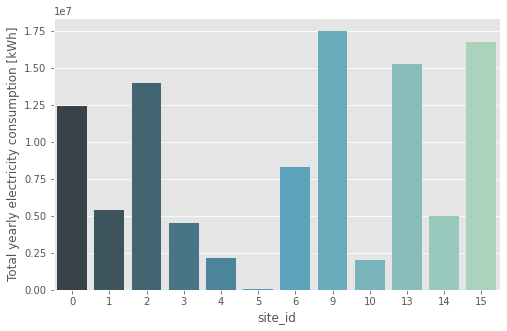

In [0]:
# Site ID vs consumption
plt.figure(figsize=(8,5))
ax = sns.barplot(x=df.groupby('site_id').sum().index, 
            y=df.groupby('site_id').sum().meter_reading,
            palette="GnBu_d")
ax.set(ylabel='Total yearly electricity consumption [kWh]')
fig = ax.get_figure()
# fig.savefig('consumption_site.png')
# files.download("consumption_site.png")

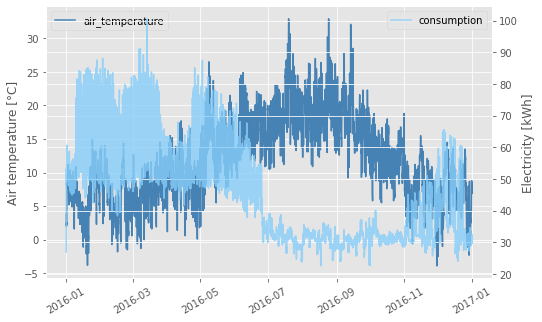

In [0]:
# Consumption vs air temperature
id_to_plot = 135

sample = df[df['building_id'] == id_to_plot]  # same train sample as above

fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set_tick_params(rotation=30, labelsize=10)
ax2 = ax.twinx()

dates = sample.index
ax2.plot_date(dates, 
              sample['meter_reading'], 
              '-', 
              color='lightskyblue', 
              label='consumption', 
              alpha=0.8)
ax.plot_date(dates, 
             sample['air_temperature'], 
             '-', 
             color='steelblue', 
             label='air_temperature')
ax.set_ylabel('Air temperature [°C]'); ax2.set_ylabel('Electricity [kWh]')
ax.legend(loc='upper left'); ax2.legend(loc='upper right')
# fig.savefig('id_135.png')
# files.download("id_135.png")

In [51]:
df.site_id.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  9, 10, 13, 14, 15], dtype=int8)

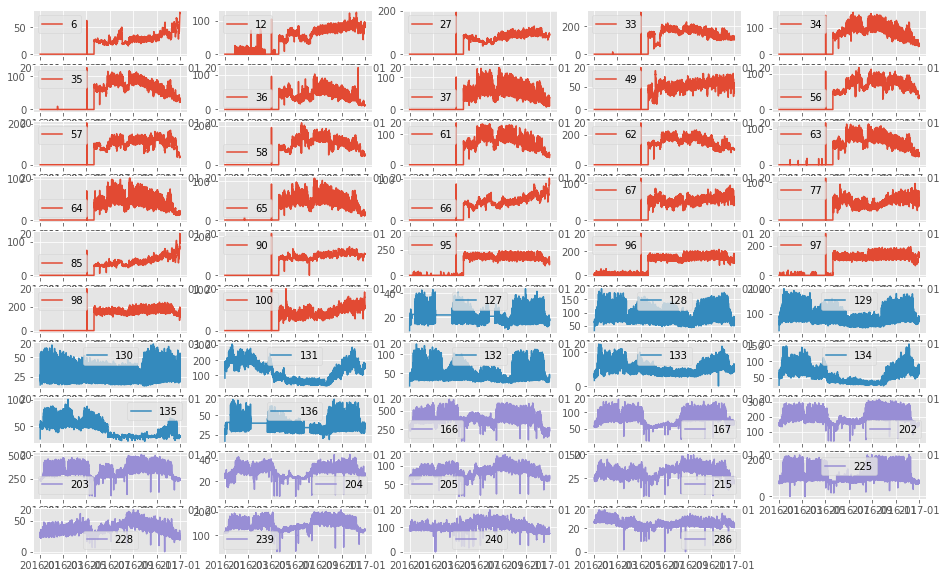

In [52]:
for i in range(1, 50):
    plt.subplot(10, 5, i)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

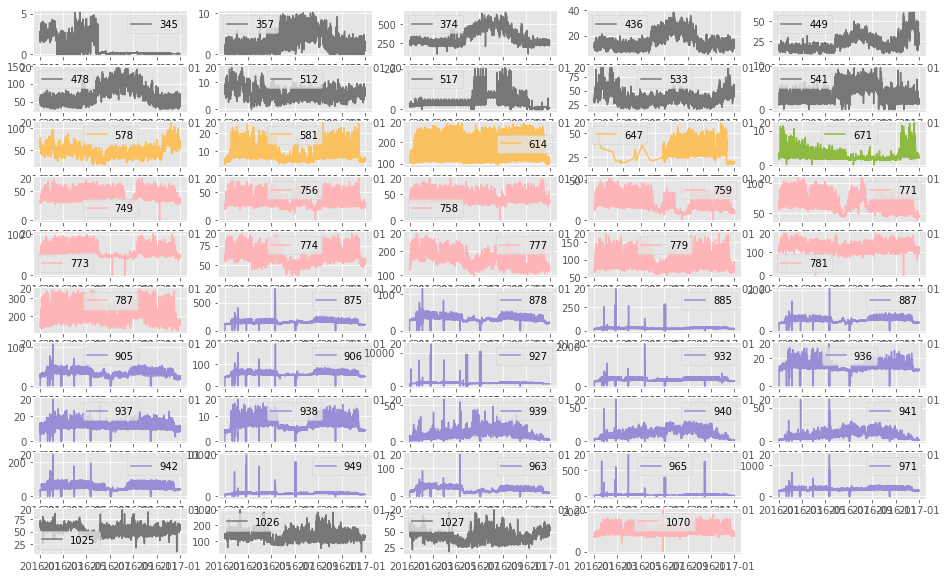

In [53]:
for i in range(51, 100):
    plt.subplot(10, 5, i-50)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

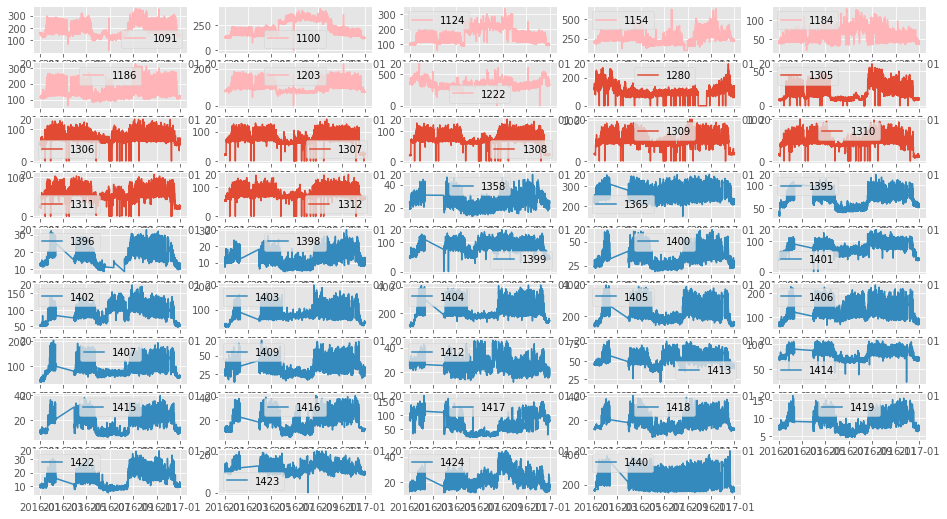

In [54]:
for i in range(101, 145):
    plt.subplot(10, 5, i-100)
    sample = df[df['building_id'] == df.building_id.unique()[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(df.building_id.unique()[i-1]))
    plt.legend()

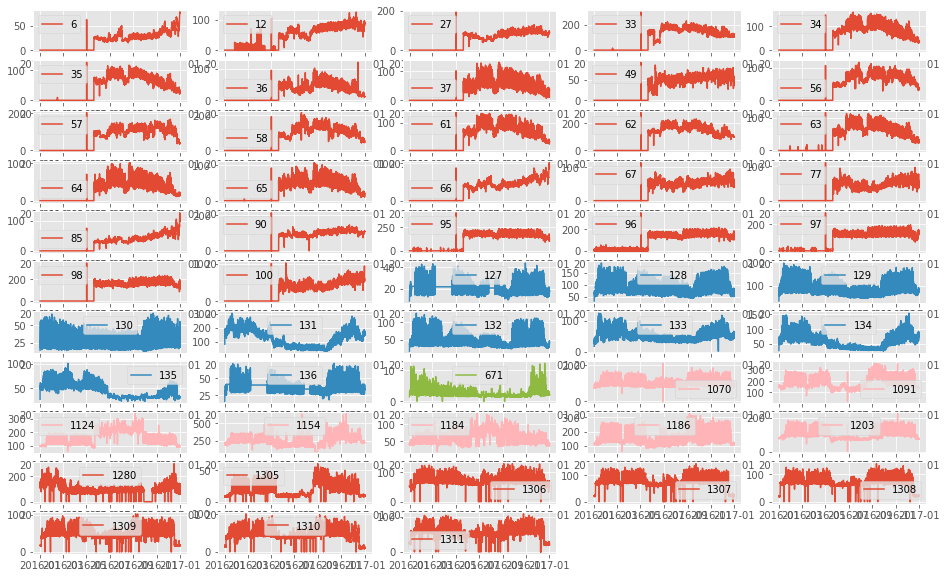

In [57]:
# Buildings with full measurements
for i in range(1, 54):
    plt.subplot(11, 5, i)
    sample = df[df['building_id'] == full_ids[i-1]] 
    dates = sample.index
    plt.plot(dates,
             sample['meter_reading'],
             color='C'+str(sample.site_id[0]),
             label=str(full_ids[i-1]))
    plt.legend()

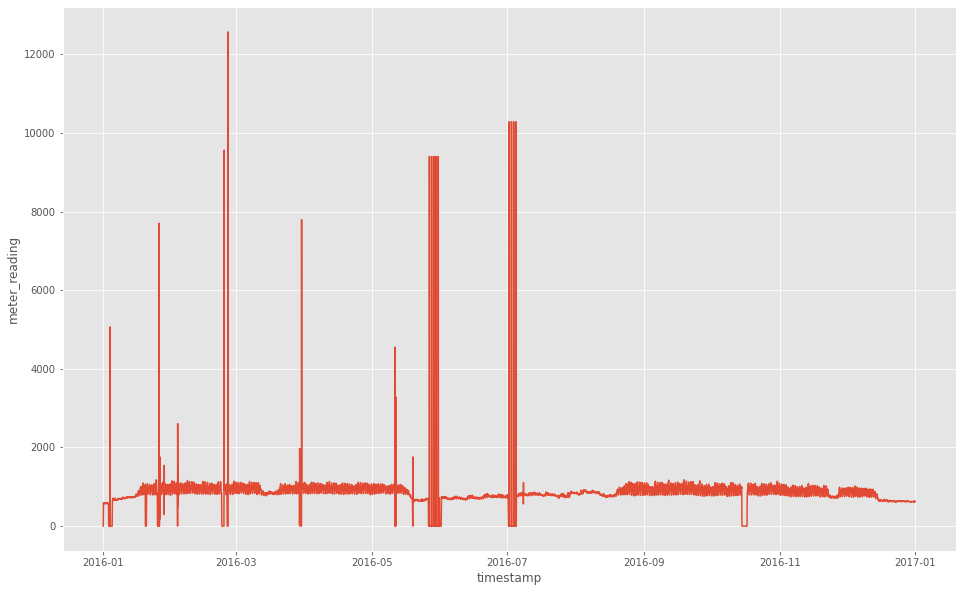

In [0]:
# Weird buildings
id_to_plot = 927 #927, 932, 971
sample = df[df['building_id'] == id_to_plot] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])

Text(0, 0.5, 'Building ID (Variance)')

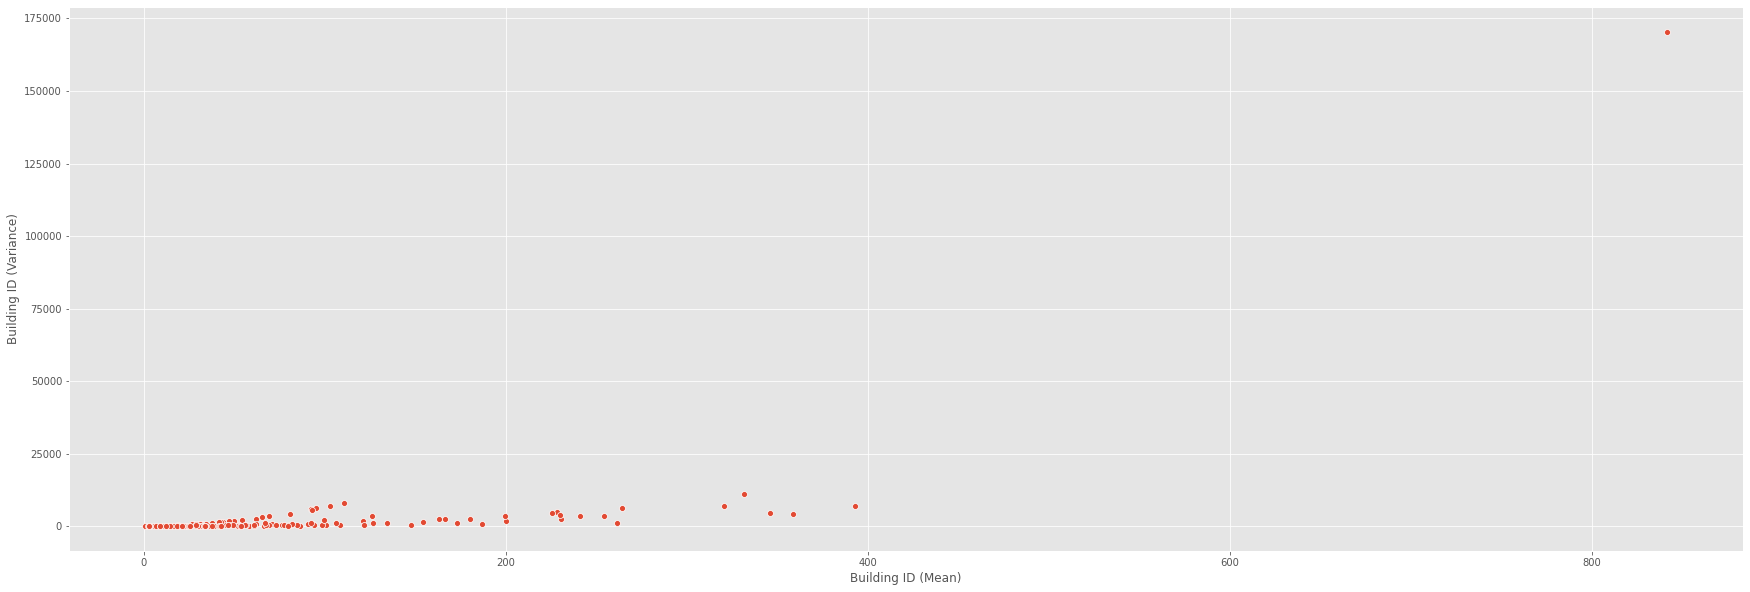

In [0]:
# Mean vs Variance
plt.figure(figsize=(30,10))
sns.scatterplot(df_mean.meter_reading, df_var.meter_reading)
plt.xlabel('Building ID (Mean)')
plt.ylabel('Building ID (Variance)')

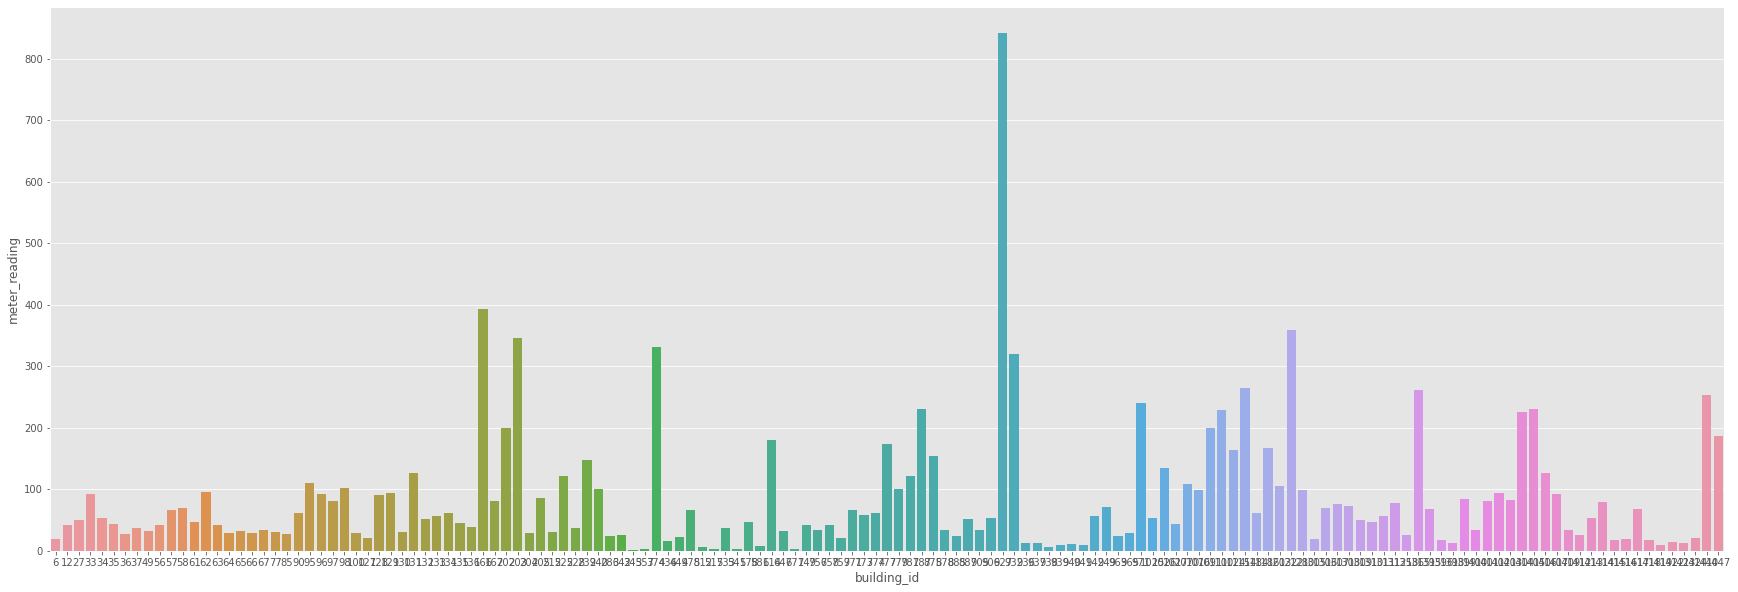

In [0]:
# Yearly mean consumption
plt.figure(figsize=(30,10))
sns.barplot(df_mean.index, df_mean.meter_reading)

# Modelling

In [0]:
# Select general parameters
forecast_day = '2016-03-14' # format: 'yyyy-mm-dd', equivalent to train %.
forecast_steps = 24
all_buildings = False # Model one building or all of them - always False for now
complete_buildings = False # Drop buildings with missing measurements - always False for now
selected_building = 478 # Select from df.building_id, e.g. 478.

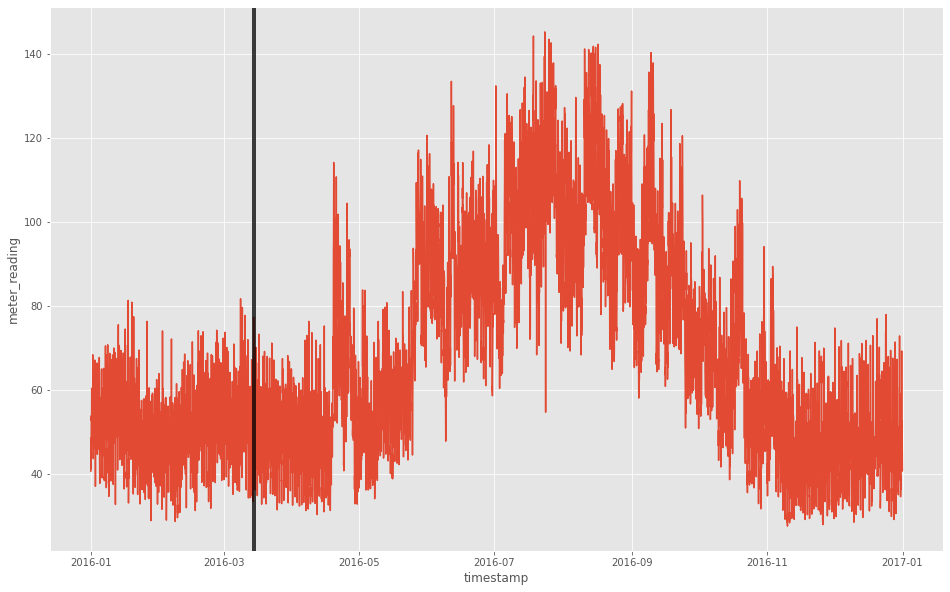

In [76]:
# Building to forecast
sample = df[df['building_id'] == selected_building] 
dates = sample.index
sns.lineplot(dates, sample['meter_reading'])
plt.axvline(pd.to_datetime(forecast_day), c='k')
plt.axvline(pd.to_datetime(forecast_day) + dt.timedelta(hours=forecast_steps), c='k')

In [0]:
# Select buildings to keep and interpolate missing X values
df = df[df.building_id != 671] # drop odd building, no sea_level_pressure
if complete_buildings:
    df = df[df.building_id.isin(full_ids)]
    df.interpolate(inplace=True)
else:
    df.interpolate(inplace=True) # max continuous is 188 for sea_level_pressure

## Feature selection

We extracted the hour, day of the week and week features from the timestamp. Intuitively power consumption should change in households during weekends, and for example vacation weeks. We one hot encode these features as well as the site_id feature. We scaled the rest of the features by subtracting the mean and dividing by the standard deviation.

### Regression

In [0]:
# Sample for regression models
if(all_buildings):
    df_small = df.copy()
    # df_small = df.sample(frac=0.1).copy()
    df_small.dropna(axis=0, inplace=True)
else:
    df_small = df[df.building_id==selected_building].copy()
    df_small.dropna(axis=0, inplace=True)

df_small['week'] = df_small.index.week
df_small['day'] =  df_small.index.weekday
df_small['hour'] =  df_small.index.hour
df_small = df_small.astype({'square_feet': 'float32',
                            'air_temperature': 'float32',
                            'dew_temperature': 'float32',
                            'sea_level_pressure': 'float32'})

In [105]:
df_small.head()

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed,week,day,hour
timestamp,,,,,,,,,,,
2016-01-01 00:00:00,478,40.7,3,31283.0,10.0,2.2,1021.0,4.1,53,4,0
2016-01-01 01:00:00,478,48.7,3,31283.0,9.4,2.8,1021.5,6.2,53,4,1
2016-01-01 02:00:00,478,45.7,3,31283.0,8.9,2.2,1021.5,4.6,53,4,2
2016-01-01 03:00:00,478,41.2,3,31283.0,7.8,1.1,1021.5,7.7,53,4,3
2016-01-01 04:00:00,478,49.3,3,31283.0,7.8,0.6,1022.0,4.1,53,4,4


In [0]:
# Prepare features matrix
X_time = np.concatenate([pd.get_dummies(df_small[x]) for x in ["week", "day", "hour"]],
                            axis=1)
if(all_buildings):
    X_building_id = pd.get_dummies(df_small.building_id)
    X_site_id = pd.get_dummies(df_small.site_id)
    X_rest = df_small.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'week', 'day', 'hour'])
    
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_time, X_building_id, X_site_id], axis=1)
else:
    X_rest = df_small.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet',
                 'week', 'day', 'hour']) # square_feet removed (constant)
    # Scale X_rest
    X_rest -= X_rest.mean()
    X_rest /= X_rest.std()

    # Join matrices
    X = np.concatenate([X_rest, X_time], axis=1)

In [0]:
# Transform target variable
y = df_small.meter_reading.values
y_mean = y.mean()
y_std = y.std()
y = (y - y_mean)/y_std

### Temporal

In [0]:
# Full DataFrame for temporal models (one building)
df_temporal = df[df.building_id == selected_building].copy()
df_temporal = df_temporal.astype({'air_temperature': 'float32',
                                  'dew_temperature': 'float32',
                                  'sea_level_pressure': 'float32'})

In [110]:
df_temporal.head()

,building_id,meter_reading,site_id,square_feet,air_temperature,dew_temperature,sea_level_pressure,wind_speed
timestamp,,,,,,,,
2016-01-01 00:00:00,478,40.7,3,31283,10.0,2.2,1021.0,4.1
2016-01-01 01:00:00,478,48.7,3,31283,9.4,2.8,1021.5,6.2
2016-01-01 02:00:00,478,45.7,3,31283,8.9,2.2,1021.5,4.6
2016-01-01 03:00:00,478,41.2,3,31283,7.8,1.1,1021.5,7.7
2016-01-01 04:00:00,478,49.3,3,31283,7.8,0.6,1022.0,4.1


In [0]:
# Prepare features matrix
if(all_buildings):
    Xt_building_id = pd.get_dummies(df_temporal.building_id)
    Xt_site_id = pd.get_dummies(df_temporal.site_id)
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet'])

    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    Xt = np.concatenate([Xt_rest, X_building_id, X_site_id], axis=1)
else:
    Xt_rest = df_temporal.drop(
        columns=['building_id', 'meter_reading', 'site_id', 'square_feet'])
    
    # Scale X_rest
    Xt_rest -= Xt_rest.mean(skipna=True)
    Xt_rest /= Xt_rest.std(skipna=True)

    # Join matrices
    Xt = Xt_rest.values

In [0]:
# Transform target variable
yt = df_temporal.meter_reading.values
yt_mean = yt.mean()
yt_std = yt.std()
yt = (yt - yt_mean) / yt_std

In [116]:
clean_idx.difference(df_temporal.index)

DatetimeIndex(['2016-03-13 02:00:00', '2016-11-06 00:00:00'], dtype='datetime64[ns]', freq=None)

## Parameters and matrices

In [114]:
# Select training weeks and general info
N, M = X.shape
Nt, Mt = Xt.shape
print('Regression models')
print('Total observations: %i' % N)
print('Features: %i\n' % M)
print('Temporal models')
print('Total observations: %i' % Nt)
print('Features: %i' % Mt)

Regression models
Total observations: 8782
Features: 88

Temporal models
Total observations: 8782
Features: 4


In [0]:
# 8782 should be 8784 (24 hours * 366 days)? check missing two hours

In [0]:
# Train/test split
# X_train, X_test, y_train, y_test = train_test_split(X, y)
forecast_dates = pd.date_range(pd.to_datetime(forecast_day),
                               pd.to_datetime(forecast_day) + dt.timedelta(hours=forecast_steps),
                               freq='H',
                               closed='left')
split_point = df_small.index.get_loc(pd.to_datetime(forecast_day))
split_point_t = df_temporal.index.get_loc(pd.to_datetime(forecast_day))

ix_train = np.random.permutation(split_point) # permute only for regression models train set
ix_test = range(split_point, split_point + forecast_steps)
ixt_train = range(0, split_point_t)
ixt_test = range(split_point_t, split_point_t + forecast_steps)

X_train = X[ix_train,:]
X_test = X[ix_test,:]
Xt_train = Xt[ixt_train,:]
Xt_test = Xt[ixt_test,:]

y_train = y[ix_train]
y_test = y[ix_test]
yt_train = yt[ixt_train]
yt_test = yt[ixt_test]

N_train = len(y_train)
N_test = len(y_test)
Nt_train = len(yt_train)
Nt_test = len(yt_test)

print('Regression models')
print("Train observations: %d" % N_train)
print("Test observations: %d\n" % N_test)
print('Temporal models')
print("Train observations: %d" % Nt_train)
print("Test observations: %d" % Nt_test)

Regression models
Train observations: 1700
Test observations: 24

Temporal models
Train observations: 1751
Test observations: 24


In [0]:
# Create a mapping between building_ids and individual ids CHECK!
mapping = {key: value for value, key in enumerate(set(df_small.building_id))}
inds = np.array([mapping[h_id] for h_id in df_small.building_id])
ind_train = inds[ix_train]
ind_test = inds[ix_test]
sites = df_small.site_id
sites_train = sites[ix_train].values
sites_test = sites[ix_test].values

In [0]:
# True values
y_true = y_test * y_std + y_mean
yt_true = yt_test * yt_std + yt_mean

## Linear Regression

In [0]:
# Fit model
lr = Ridge()
lr.fit(X_train, y_train)

# Obtain estimates
preds_lr = lr.predict(X_test) # estimates

# Convert back to the original scale
y_hat_lr = preds_lr * y_std + y_mean

In [0]:
# Coefficients
coefs = np.concatenate([[lr.intercept_],lr.coef_])
for i, coef in enumerate(coefs):
    print('β_%i: %.6f' %(i, coef))

β_0: -0.631132
β_1: 0.090904
β_2: -0.102102
β_3: 0.015386
β_4: 0.003108
β_5: 0.084045
β_6: 0.145396
β_7: -0.072168
β_8: -0.144536
β_9: -0.189914
β_10: -0.099088
β_11: 0.003129
β_12: 0.106751
β_13: 0.024278
β_14: 0.083861
β_15: 0.000000
β_16: 0.000000
β_17: 0.000000
β_18: 0.000000
β_19: 0.000000
β_20: 0.000000
β_21: 0.000000
β_22: 0.000000
β_23: 0.000000
β_24: 0.000000
β_25: 0.000000
β_26: 0.000000
β_27: 0.000000
β_28: 0.000000
β_29: 0.000000
β_30: 0.000000
β_31: 0.000000
β_32: 0.000000
β_33: 0.000000
β_34: 0.000000
β_35: 0.000000
β_36: 0.000000
β_37: 0.000000
β_38: 0.000000
β_39: 0.000000
β_40: 0.000000
β_41: 0.000000
β_42: 0.000000
β_43: 0.000000
β_44: 0.000000
β_45: 0.000000
β_46: 0.000000
β_47: 0.000000
β_48: 0.000000
β_49: 0.000000
β_50: 0.000000
β_51: 0.000000
β_52: 0.000000
β_53: 0.000000
β_54: 0.000000
β_55: 0.000000
β_56: 0.000000
β_57: 0.058154
β_58: -0.019766
β_59: -0.010787
β_60: 0.001794
β_61: 0.012393
β_62: 0.016276
β_63: 0.000338
β_64: -0.000260
β_65: -0.277971
β_66: -0.3

## Bayesian Linear Regression

In [0]:
# Convert to Tensor
X_train_torch = torch.tensor(X_train).float()
y_train_torch = torch.tensor(y_train).float()
X_test_torch = torch.tensor(X_test).float()
y_test_torch = torch.tensor(y_test).float()

# Define guide function
guide = pyro.contrib.autoguide.AutoMultivariateNormal(model_blr)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 10000

# Setup the optimizer
adam_params = {"lr": 0.001} # learning rate (lr) of optimizer
optimizer = pyro.optim.ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = pyro.infer.Trace_ELBO(num_particles=1)
svi = pyro.infer.SVI(model_blr, guide, optimizer, loss=elbo)

In [0]:
# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train_torch, y_train_torch)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


[0] ELBO: 3519.1
[1000] ELBO: 711.8
[2000] ELBO: 817.1
[3000] ELBO: 437.8
[4000] ELBO: 401.8
[5000] ELBO: 393.0
[6000] ELBO: 330.4
[7000] ELBO: 362.3
[8000] ELBO: 402.1
[9000] ELBO: 338.2


In [0]:
# Use predictive from pyro
predictive = pyro.infer.Predictive(model_blr, guide=guide, num_samples=1000,
                        return_sites=("alpha", "beta", "sigma"))
samples = predictive(X_test_torch)
#samples = predictive(X_train_torch, y_train_torch)

# Get samples and estimates
alpha_samples = samples["alpha"].detach().numpy()
beta_samples = samples["beta"].detach().numpy()
preds_blr = np.mean(alpha_samples.T + np.dot(X_test, beta_samples.T), axis=1)

# Convert back to the original scale
y_hat_blr = preds_blr * y_std + y_mean

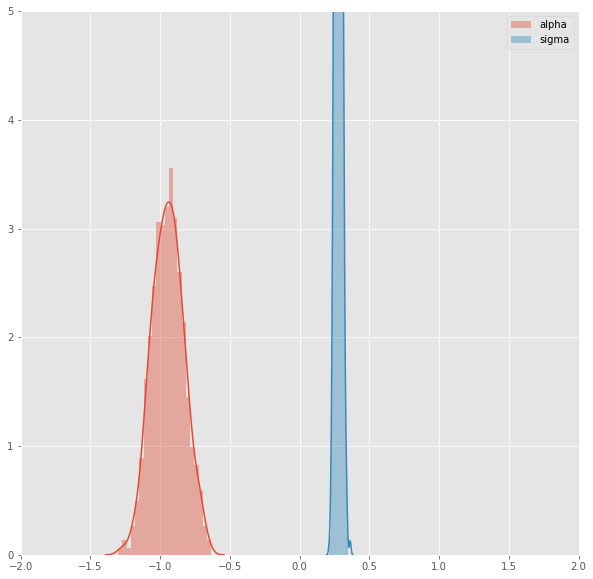

In [0]:
# Intercept and error
plt.figure(figsize=(10,10))
sns.distplot(alpha_samples)
sns.distplot(samples["sigma"].detach().numpy())
plt.legend(["alpha", "sigma"])
plt.axis([-2,2,0,5]);

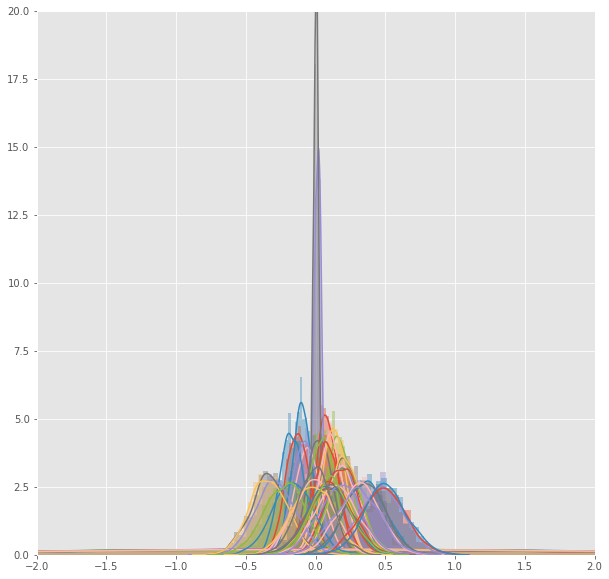

In [0]:
# Beta parameters
plt.figure(figsize=(10,10))
for i in range(M):
    sns.distplot(beta_samples[:, i])
#plt.legend(["beta%d" % i for i in range(M)])
plt.axis([-2,2,0,20])
plt.show()

## Hierarchical Model

In [0]:
# Parameters
batch_size = 64
EPOCHS = 20

n_households = len(df.building_id.unique()) -1 # one cat for each household
n_areas = len(set(df.site_id)) -1

In [0]:
# Set optimizer with learning rate
adam = optim.ClippedAdam(0.001)

# Define guide
guide = AutoMultivariateNormal(model_hierarchical)

# Setup inference algorithm
svi = SVI(model_hierarchical, guide, adam, ELBO())

# Set batch sizes to sample matrices
rng_key = random.PRNGKey(0)
rng_key, rng_key_init = random.split(rng_key, 2)
sample_X = X_train[0:batch_size]
sample_y = y_train[0:batch_size]
sample_site = sites_train[0:batch_size]
sample_ind = ind_train[0:batch_size]

svi_state = svi.init(rng_key_init,
                     sample_X,
                     sample_ind,
                     n_households,
                     sample_site,
                     n_areas,
                     sample_y)

In [0]:
for e in range(EPOCHS):
    # Train
    svi_state, loss = lax.scan(train_step,
                               svi_state,
                               xs=(X_train, ind_train, sites_train, y_train))
    loss = loss.mean()
    # Eval
    test_loss = svi.evaluate(svi_state,
                             X_test,
                             ind_test,
                             n_households,
                             sites_test,
                             n_areas,
                             y_test) / len(X_test)
    print(f"Epoch: {e}, Train Loss: {loss}, Test Loss: {test_loss}")

In [0]:
predictive_hm = Predictive(model=hierarchical_model,
                        guide=guide,
                        num_samples=1000,
                        return_sites=("alpha_mu", "beta_mu", "alpha", "beta"),
                        parallel=True)
samples_hm = predictive.get_samples(rng_key,
                                 X_train,
                                 ind_train,
                                 n_households,
                                 sites_train,
                                 n_areas,
                                 y_train)

# Extract expected values of the parameters
alpha_hat = samples["alpha"].mean(axis=0)
beta_hat = samples["beta"].mean(axis=0)

# Make predictions for test set
y_hat_hm = alpha_hat[ind_test-1] + np.dot(X_test, beta_hat[sites_test-1,:].T)
y_hat_hm = y_hat_hm.mean(axis=1)

# Convert back to the original scale
preds_hm = y_hat_hm * y_std + y_mean

In [0]:
sns.distplot(samples['alpha_mu'])

In [0]:
for i in range(samples["beta_mu"].shape[1]):
    sns.distplot(samples["beta_mu"][:,i])

In [0]:
sns.distplot(alpha_hat)

In [0]:
for i in range(beta_hat.shape[1]):
    sns.distplot(beta_hat[:,i])

## Linear Dynamical Systems (LDS)

In [0]:
# numpyro.set_host_device_count(2) to change num_chains

### AR1

In [0]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
# nuts_kernel = NUTS(model=model_AR1, max_tree_depth=8) # 4.59e-3
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [02:29<00:00, 26.71it/s, 255 steps of size 4.59e-03. acc. prob=0.97]


Total time: 2.546m


In [0]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      1.00      0.00      1.00      1.00      1.00      5.53      1.30
   noises[0]     -0.10      1.06      0.01     -2.10      1.49      8.61      1.07
   noises[1]      0.54      0.77      0.42     -0.61      1.98     14.06      1.00
   noises[2]     -0.44      0.99     -0.33     -2.46      0.92     15.40      1.06
   noises[3]      0.21      0.67      0.20     -0.72      1.42     12.41      1.34
   noises[4]     -0.82      0.54     -0.95     -1.75      0.02      2.87      2.32
   noises[5]      0.21      1.00      0.20     -1.42      1.72     84.64      1.00
   noises[6]      0.05      1.05     -0.10     -1.38      1.72      5.05      1.05
   noises[7]     -0.29      0.97     -0.29     -1.91      1.12     25.73      1.01
   noises[8]      1.01      0.72      1.18     -0.13      2.08      8.27      1.00
   noises[9]      0.33      0.53      0.43     -0.54      1.07      5.25      1.83
  n

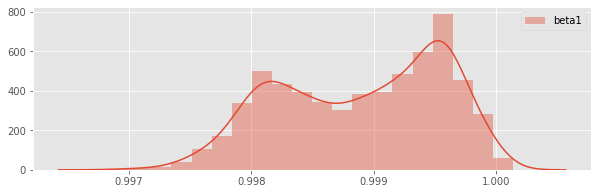

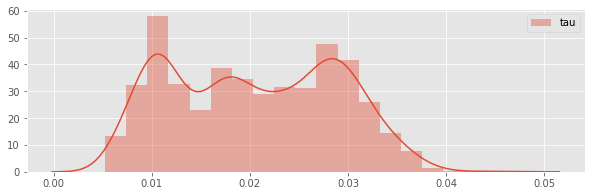

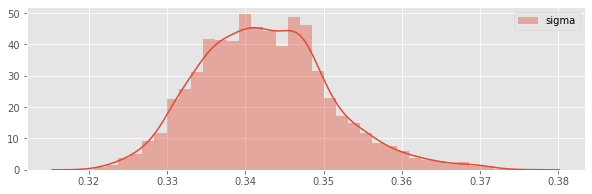

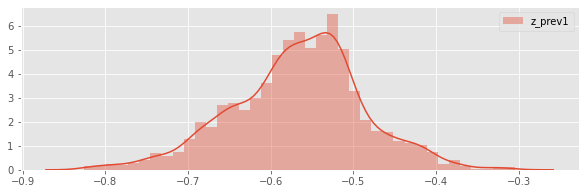

In [0]:
# Get parameter samples
hmc_samples_ar1 = mcmc.get_samples()
nodes_ar1 = ["beta1", "tau", "sigma", "z_prev1"]
for node in nodes_ar1:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar1[node], label=node)
    plt.legend()
    plt.show()

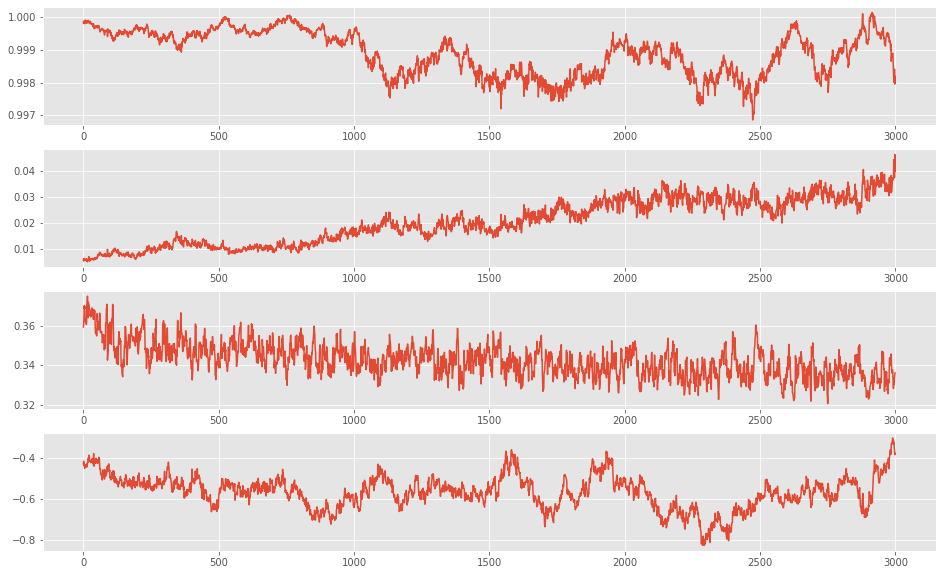

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)
ax1.plot(hmc_samples_ar1['beta1'])
ax2.plot(hmc_samples_ar1['tau'])
ax3.plot(hmc_samples_ar1['sigma'])
ax4.plot(hmc_samples_ar1['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1 = compute_predictions(hmc_samples_ar1["y_hat"], yt_std, yt_mean)

### AR2

In [0]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR2)
# nuts_kernel = NUTS(model=model_AR2, max_tree_depth=8, step_size=5e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [10:28<00:00,  6.37it/s, 1023 steps of size 1.99e-04. acc. prob=0.95]


Total time: 10.643m


In [0]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.51      0.08      0.51      0.39      0.64      6.67      1.16
       beta2      0.49      0.08      0.49      0.36      0.61      6.67      1.16
   noises[0]      0.83      0.77      0.72     -0.24      2.14      5.94      1.14
   noises[1]     -0.49      0.35     -0.53     -1.14     -0.01      2.99      1.92
   noises[2]     -0.71      0.54     -0.71     -1.44      0.21      5.05      1.00
   noises[3]     -0.78      0.31     -0.83     -1.26     -0.32      7.05      1.01
   noises[4]      0.64      0.87      0.54     -0.66      1.93      6.96      1.15
   noises[5]      0.14      0.33      0.17     -0.30      0.64      7.11      1.00
   noises[6]     -0.20      0.44     -0.07     -1.01      0.34      5.34      1.23
   noises[7]      0.34      0.98      0.40     -1.05      1.81      4.56      1.35
   noises[8]      0.50      0.58      0.69     -0.60      1.15      4.00      1.27
   

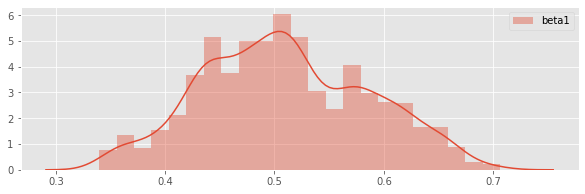

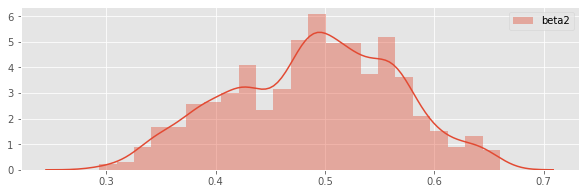

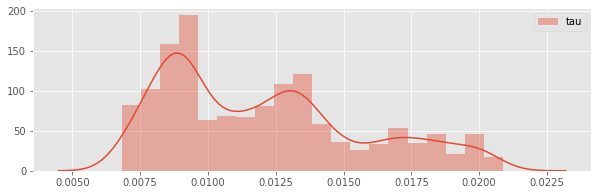

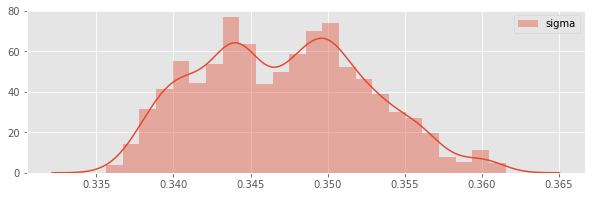

In [0]:
# Get parameter samples
hmc_samples_ar2 = mcmc.get_samples()
nodes_ar2 = ["beta1", "beta2", "tau", "sigma"]
for node in nodes_ar2:
    plt.figure(figsize=(10,3))
    sns.distplot(hmc_samples_ar2[node], label=node)
    plt.legend()
    plt.show()

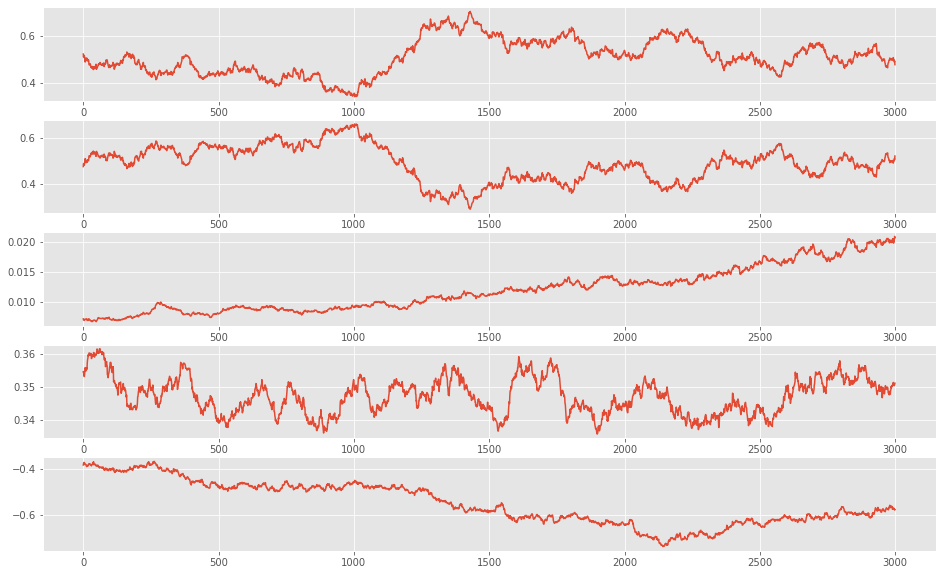

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar2['beta1'])
ax2.plot(hmc_samples_ar2['beta2'])
ax3.plot(hmc_samples_ar2['tau'])
ax4.plot(hmc_samples_ar2['sigma'])
ax5.plot(hmc_samples_ar2['z_prev1'])

In [0]:
# Get predictions
y_hat_ar2 = compute_predictions(hmc_samples_ar2["y_hat"], yt_std, yt_mean)

### AR24

In [0]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR24, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
# 1.27e-3 with adapt
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [04:10<00:00, 15.99it/s, 255 steps of size 1.00e-02. acc. prob=0.95]


Total time: 4.672m


In [0]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.88      0.03      0.88      0.84      0.93      3.50      1.80
      beta24      0.12      0.03      0.12      0.07      0.16      3.51      1.80
   noises[0]     -1.65      0.12     -1.66     -1.82     -1.47      2.70      2.36
   noises[1]     -1.16      0.12     -1.15     -1.31     -0.94      3.81      1.69
   noises[2]      2.08      0.07      2.09      1.96      2.16      3.48      1.92
   noises[3]     -1.08      0.08     -1.07     -1.23     -0.96      6.01      1.01
   noises[4]     -0.21      0.14     -0.26     -0.38      0.02      2.58      2.73
   noises[5]     -1.20      0.09     -1.18     -1.32     -1.06      2.88      2.10
   noises[6]     -0.71      0.12     -0.66     -0.90     -0.57      3.09      2.33
   noises[7]     -1.93      0.10     -1.89     -2.13     -1.81      4.44      1.23
   noises[8]      2.13      0.09      2.11      2.01      2.30      5.76      1.05
   

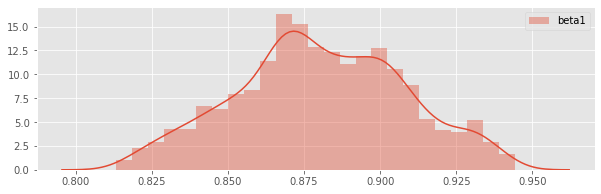

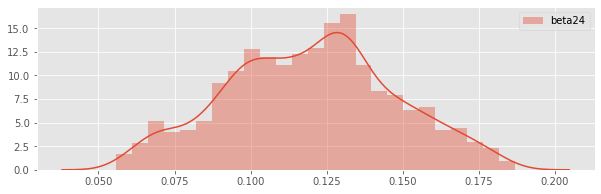

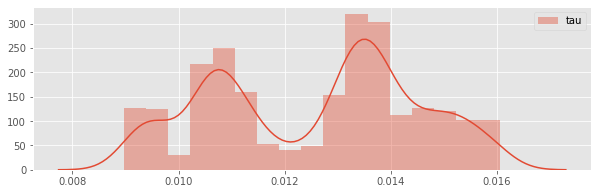

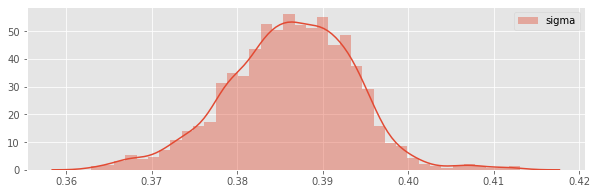

In [0]:
# Get parameter samples
hmc_samples_ar24 = mcmc.get_samples()
nodes_ar24 = ["beta1", "beta24", "tau", "sigma"]
for node in nodes_ar24:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar24[node], label=node)
  plt.legend()
  plt.show()

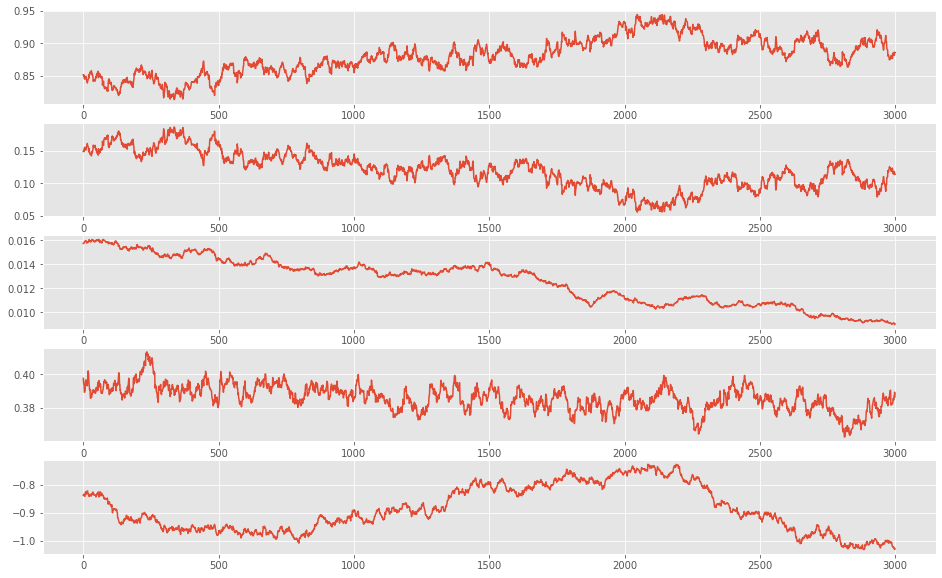

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar24['beta1'])
ax2.plot(hmc_samples_ar24['beta24'])
ax3.plot(hmc_samples_ar24['tau'])
ax4.plot(hmc_samples_ar24['sigma'])
ax5.plot(hmc_samples_ar24['z_prev1'])

In [0]:
# Get predictions
y_hat_ar24 = compute_predictions(hmc_samples_ar24["y_hat"], yt_std, yt_mean)

### AR168

In [0]:
# Start time
tic = time.time()

# Run MCMC
nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8)
#nuts_kernel = NUTS(model=model_AR168, max_tree_depth=8, step_size=5e-3, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [19:48<00:00,  3.37it/s, 255 steps of size 1.90e-03. acc. prob=0.89]


Total time: 28.821m


In [0]:
mcmc.print_summary()

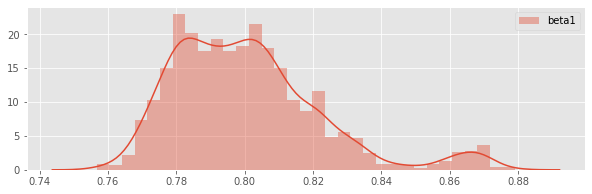

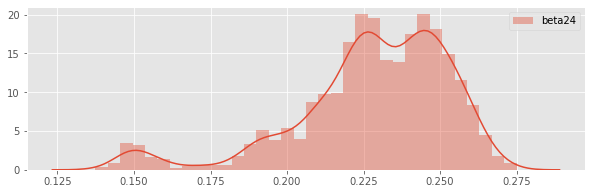

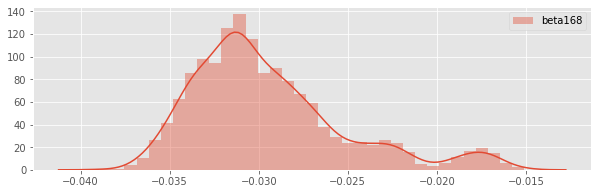

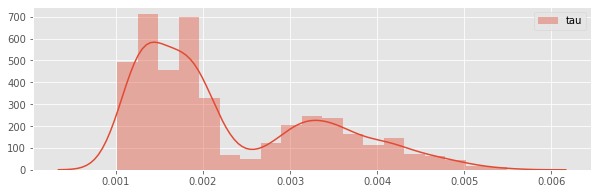

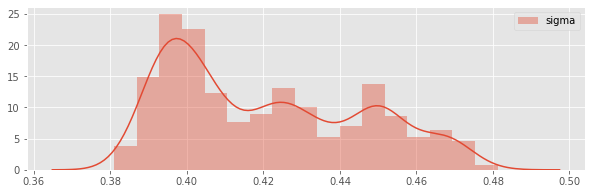

In [0]:
# Get parameter samples
hmc_samples_ar168 = mcmc.get_samples()
nodes_ar168 = ["beta1", "beta24", "beta168", "tau", "sigma"]
for node in nodes_ar168:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar168[node], label=node)
  plt.legend()
  plt.show()

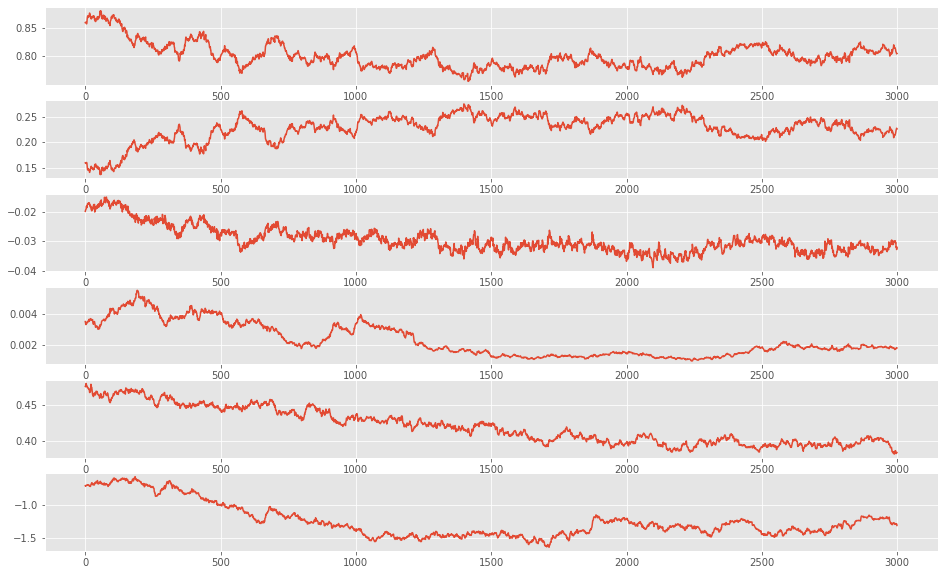

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1)
ax1.plot(hmc_samples_ar168['beta1'])
ax2.plot(hmc_samples_ar168['beta24'])
ax3.plot(hmc_samples_ar168['beta168'])
ax4.plot(hmc_samples_ar168['tau'])
ax5.plot(hmc_samples_ar168['sigma'])
ax6.plot(hmc_samples_ar168['z_prev1'])

In [0]:
# Get predictions
y_hat_ar168 = compute_predictions(hmc_samples_ar168["y_hat"], yt_std, yt_mean)

### AR1 + Inputs

In [0]:
# Start time
tic = time.time()

X_t = np.concatenate([Xt_train[1:,:], Xt_test], axis=0)
# X_t = np.concatenate([Xt_train[0][np.newaxis, :], Xt_train, Xt_test], axis=0)
# X_t = np.concatenate([Xt_train, Xt_test], axis=0)

# Run MCMC
nuts_kernel = NUTS(model=model_AR1_inputs, max_tree_depth=8)
# nuts_kernel = NUTS(model=model_AR1_inputs, max_tree_depth=8, step_size=1e-2, adapt_step_size=False)
mcmc = MCMC(nuts_kernel, num_samples=3000, num_warmup=1000, num_chains=1)
mcmc.run(rng_key_, T=Nt_train, T_forecast=Nt_test, X=X_t, obs=yt_train)

# End time
toc = time.time()

print("Total time: {0:.3f}m".format((toc - tic)/60))

sample: 100%|██████████| 4000/4000 [05:24<00:00, 12.31it/s, 511 steps of size 1.31e-02. acc. prob=0.77]


Total time: 5.492m


In [0]:
mcmc.print_summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
       beta1      0.77      0.02      0.77      0.74      0.80     87.38      1.00
      eta[0]      0.11      0.02      0.11      0.08      0.15    249.19      1.00
      eta[1]     -0.01      0.02     -0.01     -0.04      0.03    252.87      1.00
      eta[2]      0.02      0.01      0.02      0.01      0.03    344.32      1.00
      eta[3]      0.00      0.01      0.00     -0.01      0.01    319.88      1.01
   noises[0]      0.39      0.28      0.39     -0.06      0.83   2396.32      1.00
   noises[1]     -0.79      0.27     -0.79     -1.23     -0.34   2898.65      1.00
   noises[2]     -1.04      0.28     -1.04     -1.51     -0.60   1444.65      1.00
   noises[3]      0.45      0.28      0.45      0.03      0.92   3066.88      1.00
   noises[4]     -0.14      0.28     -0.14     -0.60      0.28   1873.30      1.00
   noises[5]      0.22      0.27      0.21     -0.22      0.68   3018.85      1.00
   

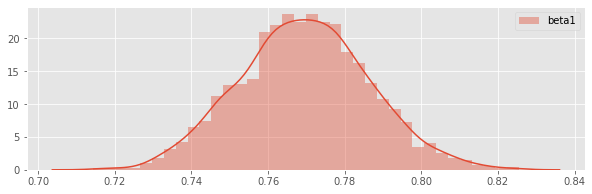

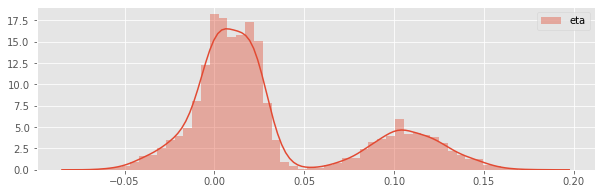

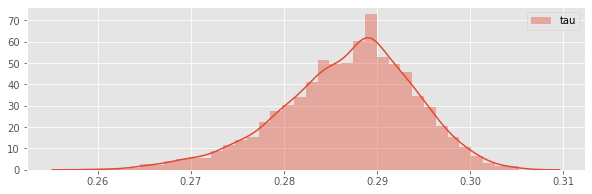

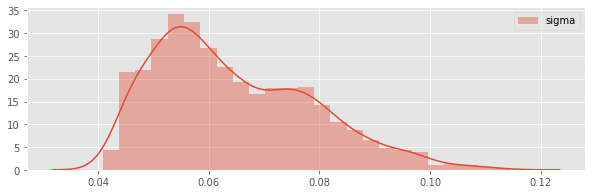

In [0]:
# Get parameter samples
hmc_samples_ar1x = mcmc.get_samples()
nodes_ar1x = ["beta1", "eta","tau", "sigma"]
for node in nodes_ar1x:
  plt.figure(figsize=(10,3))
  sns.distplot(hmc_samples_ar1x[node], label=node)
  plt.legend()
  plt.show()

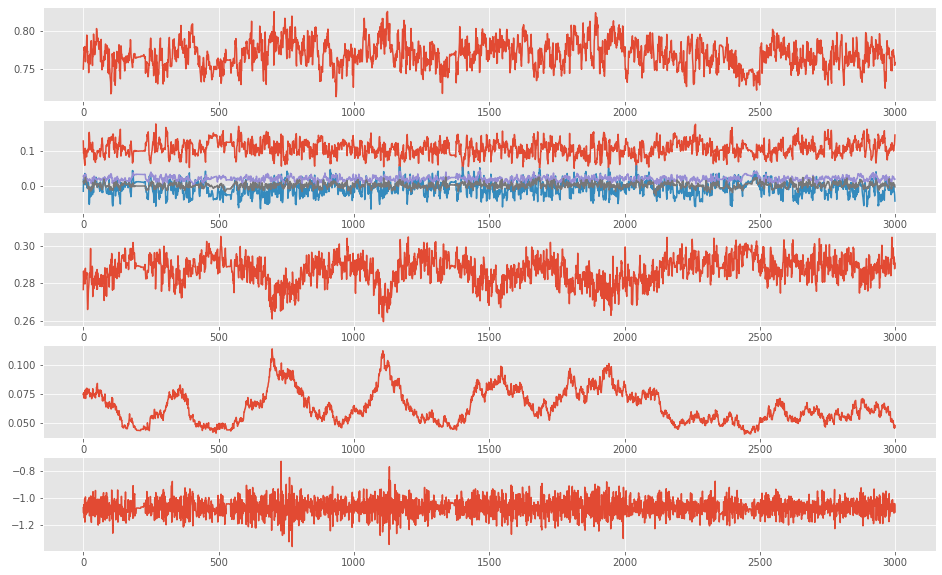

In [0]:
# Trace plot
f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
ax1.plot(hmc_samples_ar1x['beta1'])
ax2.plot(hmc_samples_ar1x['eta'])
ax3.plot(hmc_samples_ar1x['tau'])
ax4.plot(hmc_samples_ar1x['sigma'])
ax5.plot(hmc_samples_ar1x['z_prev1'])

In [0]:
# Get predictions
y_hat_ar1x = compute_predictions(hmc_samples_ar1x["y_hat"], yt_std, yt_mean)

### AR24 + Inputs

### AR168 + Inputs

# Results

In [0]:
# Compute errors
e_lr = compute_error(y_true, y_hat_lr)
e_blr = compute_error(y_true, y_hat_blr)
e_ar1 = compute_error(yt_true, y_hat_ar1)
# e_ar2 = compute_error(yt_true, y_hat_ar2)
# e_ar24 = compute_error(yt_true, y_hat_ar24)
# e_ar168 = compute_error(yt_true, y_hat_ar168)
e_ar1x = compute_error(yt_true, y_hat_ar1x)
errors = [e_lr, e_blr, e_ar1, e_ar1x]
# errors = [e_lr, e_blr, e_ar1, e_ar2, e_ar24, e_ar168, e_ar1x]

# Save errors to DataFrame and show
pd.set_option('float_format', '{:.3f}'.format)
df_results = pd.DataFrame(data=errors,
                          index=['Linear Regression',
                                 'Bayesian LR',
                                 'AR1',
                                 #'AR2',
                                 #'AR24',
                                 #'AR168',
                                 'AR1x',
                                 ],
                          columns=['CORR', 'MAE', 'RAE', 'RMSE', 'R2'])
df_results

,CORR,MAE,RAE,RMSE,R2
Linear Regression,0.506,6.239,0.857,8.365,0.245
Bayesian LR,0.502,6.292,0.865,8.494,0.222
AR1,0.054,8.037,1.105,10.457,0.000
AR1x,0.503,10.546,1.449,12.197,0.000


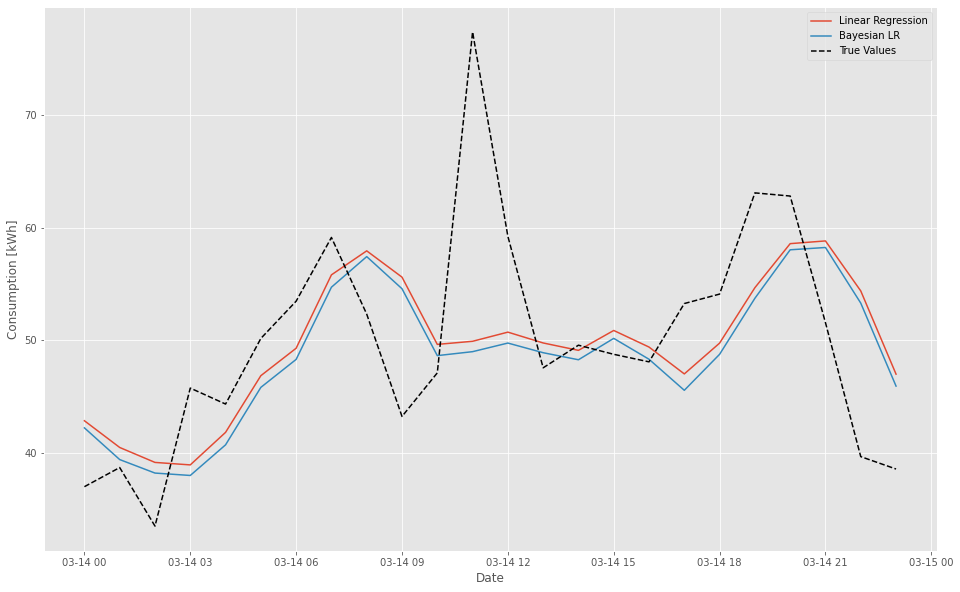

In [0]:
# Plot forecast
# Note: add previous 3-5 days
plt.plot(forecast_dates, y_hat_lr, label='Linear Regression')
plt.plot(forecast_dates, y_hat_blr, label='Bayesian LR')
plt.plot(forecast_dates, y_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()

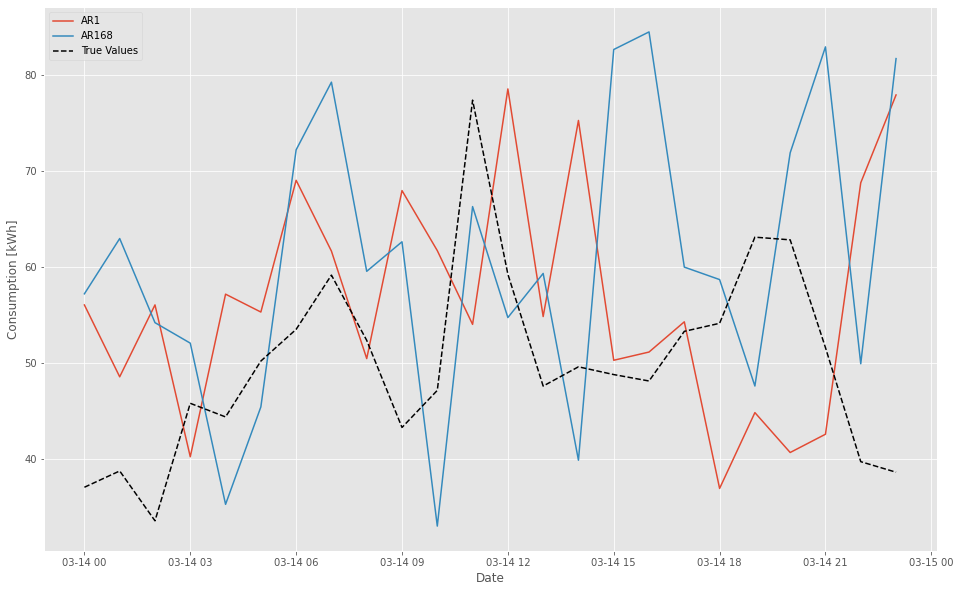

In [0]:
# Plot forecast
# Note: add previous 3-5 days
plt.plot(forecast_dates, y_hat_ar1, label='AR1')
#plt.plot(forecast_dates, y_hat_ar2, label='AR2')
#plt.plot(forecast_dates, y_hat_ar24, label='AR24')
plt.plot(forecast_dates, y_hat_ar168, label='AR168')
plt.plot(forecast_dates, yt_true, 'k--', label='True Values')
plt.ylabel('Consumption [kWh]')
plt.xlabel('Date')
plt.legend()

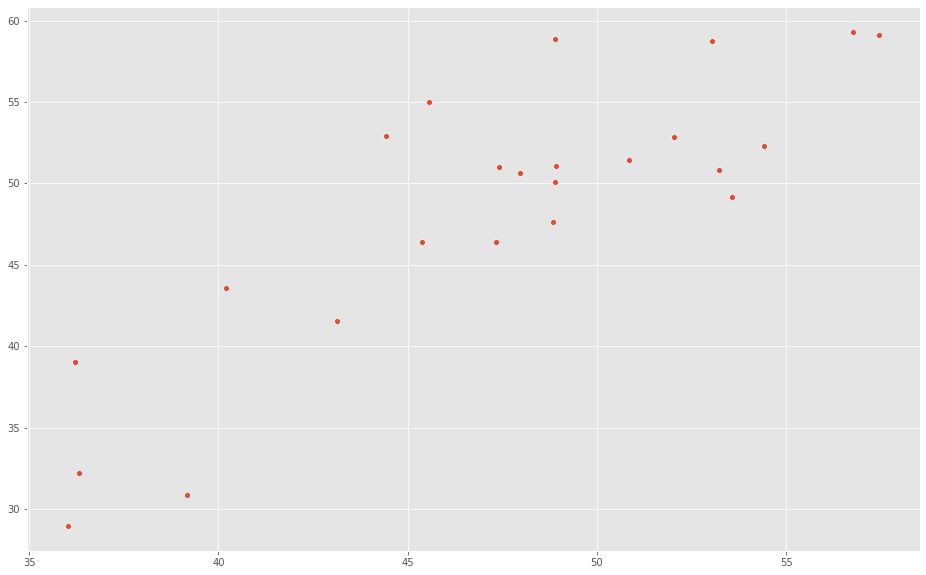

In [0]:
# Linear regression
sns.scatterplot(preds_lr, y_true)

# Unused

In [0]:
# Generate descriptive statistics reports
# If it doesn't work try uninstalling pandas-profiling, re-install it, and restart runtime
profile_meta = ProfileReport(df_meta,
                             title='Building info',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_data = ProfileReport(df,
                             title='Electricity consumption in households',
                             minimal=True,
                             html={'style':{'full_width':True}})
profile_weather = ProfileReport(df_weather,
                                title='Weather',
                                minimal=True,
                                html={'style':{'full_width':True}})

In [0]:
# Export reports
# profile_meta.to_file(output_file="info.html")
# profile_weather.to_file(output_file="weather.html")
# profile_data.to_file(output_file="data.html")
# files.download('info.html')
# files.download('weather.html')
# files.download('data.html')